In [1]:
import site
site.addsitedir('../tmxutil')

import re
import notebook
from tqdm.autonotebook import tqdm
from tmxutil import make_reader, TranslationUnit, TranslationUnitVariant
from collections import Counter
from stats import RandomSample
from IPython.display import display

from logging import getLogger, ERROR
getLogger().setLevel(ERROR) # Hide warnings while importing

<ipython-input-1-00722bce6e28>:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import notebook
import importlib
notebook = importlib.reload(notebook)

In [3]:
def domain(url):
    """Take the (very broadly defined) domain part of an url, or return the
    full url if that didn't work."""
    match = re.match(r'^(https?:)?(//)?(?P<domain>[^/]+)', url)
    return match.group('domain')

# Some tests
[
    domain("ikhoefgeen.nl/test"),
    domain("http://this.is.test.com/facebook.com/test&stuff=false"),
]

['ikhoefgeen.nl', 'this.is.test.com']

In [4]:
filename = 'en-mt.cc-2016-30-cc-2017-30-cc-2018-30-cc-2019-18-cc-2019-35-gwb-hieu-marta-philipp-wide00006-wide00015.tmx.gz'
lang_pair = ['en', 'mt']
# filename = "es-eu.merged.tmx.gz"
# lang_pair = ['es', 'eu']

def read():
    with open(filename, 'rb') as fh:
        for unit in make_reader(fh, progress=True):
            yield unit

In [5]:
_units = list(read())
read = lambda: tqdm(_units)

en-mt.cc-2016-30-cc-2017-30-cc-2018-30-cc-2019-18-cc-2019-35-gwb-hieu-marta-philipp-wide00006-wide00015.tmx.gz…

# Most occurring domains
Domains that occur most often in all mentioned urls (per language of the language pair)

In [6]:
counters = {lang: Counter() for lang in lang_pair}

for unit in read():
    for lang in lang_pair:
        counters[lang].update(domain(url) for url in unit.translations[lang]['source-document'])

  0%|          | 0/1604135 [00:00<?, ?it/s]

In [7]:
for lang in lang_pair:
    display(lang, notebook.table(counters[lang].most_common(10), headers=['Domain', 'Count']))

'en'

Domain,Count
m.facebook.com,1970366
www.ecb.europa.eu,821574
eur-lex.europa.eu,791772
www.eea.europa.eu,567333
echa.europa.eu,457832
europa.eu,392123
ec.europa.eu,383492
www.europeana.eu,380842
www.europarl.europa.eu,320333
curia.europa.eu,278415


'mt'

Domain,Count
eur-lex.europa.eu,454072
www.ecb.europa.eu,446953
www.eea.europa.eu,344306
europa.eu,308153
ec.europa.eu,261313
www.europarl.europa.eu,235195
echa.europa.eu,179860
e-justice.europa.eu,134125
konvertitur.kingconv.com,118733
www.plus500.com.mt,110795


### Facebook domains
What are these Facebook urls? How many are there? What do their sentence pairs look like?

In [8]:
facebook_sample = RandomSample(100)

for unit in read():
    if any(domain(url) == 'm.facebook.com'
           for translation in unit.translations.values()
           for url in translation['source-document']):
        facebook_sample.add(unit)

for unit in facebook_sample:
    for lang, variant in unit.translations.items():
        print(unit['id'])
        print(f"{lang}: {variant.text}")
        print("    ({})".format(Counter(domain(url) for url in variant['source-document']).most_common(5)))
    print()

  0%|          | 0/1604135 [00:00<?, ?it/s]

/Users/jelmer/Workspace/statmt/paracrawl/stats.py:15: PopulationSizeWarning: Population (size 12) smaller than sample (size 100)
  warnings.warn('Population (size {}) smaller than sample (size {})'.format(self.n + 1, self.size), PopulationSizeWarning)


{'211029'}
en: To connect with Billogram, join Facebook today.
    ([('m.facebook.com', 2)])
{'211029'}
mt: Per connetterti con Billogram, iscriviti subito a Facebook.
    ([('m.facebook.com', 1)])

{'622688'}
en: Find Your Account Facebook
    ([('m.facebook.com', 49)])
{'622688'}
mt: Sib il-Kont Tiegħek Facebook
    ([('m.facebook.com', 49)])

{'653201'}
en: Phone number or email address
    ([('m.facebook.com', 1820161)])
{'653201'}
mt: Numru tal-Mowbajl jew Email
    ([('m.facebook.com', 560)])

{'692544'}
en: Mobile number or email
    ([('m.facebook.com', 10)])
{'692544'}
mt: Numru tal-Mowbajl jew Email
    ([('m.facebook.com', 12)])

{'725079'}
en: Renew Magazine is on Facebook.
    ([('m.facebook.com', 2)])
{'725079'}
mt: Renew Magazine รจ su Facebook.
    ([('m.facebook.com', 1)])

{'847877'}
en: Phone number or email
    ([('m.facebook.com', 552)])
{'847877'}
mt: Numru tal-Mowbajl jew Email
    ([('m.facebook.com', 543)])

{'1036188'}
en: INTO THE NIGHT - Community | Facebook

# Sentence pairs with the most urls associated with them
What kind of sentence pairs occur apparently everywhere? These are the sentence pairs with the most urls associated with them. (Note: url, not most different domains.)

In [9]:
from heapq import nlargest

def unit_url_count():
    for unit in read():
        yield sum(len(translation['source-document']) for translation in unit.translations.values()), unit

units_with_most_urls = nlargest(50, unit_url_count(), key=lambda entry: entry[0])

  0%|          | 0/1604135 [00:00<?, ?it/s]

In [10]:
for count, unit in units_with_most_urls:
    domains = Counter(domain(url)
                  for translation in unit.translations.values()
                  for url in translation['source-document'])
    print(f"Unit has {count} urls attached to it")
    for lang, translation in unit.translations.items():
        print(f"{lang}: {translation.text}")
    for domain_name, count in domains.most_common(10):
        print(f"  {count}: {domain_name}")
    print()

Unit has 1820721 urls attached to it
en: Phone number or email address
mt: Numru tal-Mowbajl jew Email
  1820721: m.facebook.com

Unit has 149676 urls attached to it
en: Mobile number or email address
mt: Numru tal-Mowbajl jew Email
  149676: m.facebook.com

Unit has 55277 urls attached to it
en: privacy policy
mt: politika dwar il-privatezza
  35764: en.wikipedia.org
  4487: simple.wikipedia.org
  2650: mt.wikipedia.org
  2104: commons.wikimedia.org
  765: wiki.banana-pi.org
  665: en.wiktionary.org
  600: defensewiki.ibj.org
  594: ec.europa.eu
  420: www.ecb.europa.eu
  306: mt.wiktionary.org

Unit has 41249 urls attached to it
en: List of Firms
mt: Lista ta ' ditti
  6475: tintesdecabello.net
  5378: beautybazar.net
  4829: keratine.it
  4809: migliortintacapelli.it
  3016: beautybazar.de
  2914: beautybazar.cn
  2913: beautybazar.co.uk
  2695: beautybazar.com
  2674: beautybazar.fr
  2589: beautybazar.it

Unit has 40631 urls attached to it
en: ■ Scissors for Hair
mt: ■ Mqassijiet 

# Domain with most sentence pairs
Similar to above, but counting a domain only once when it occurs multiple times in a sentence pair. (I expect Facebook to score a lot lower on this measurement.)

This is a better measure of which domains are a good source for language pairs I suppose.

In [11]:
sentence_domains = {lang: Counter() for lang in lang_pair}

for unit in read():
    for lang in lang_pair:
        sentence_domains[lang].update(frozenset(domain(url) for url in unit.translations[lang]['source-document']))

  0%|          | 0/1604135 [00:00<?, ?it/s]

In [12]:
notebook.table(((lang, sentence_domains[lang].most_common(10)) for lang in lang_pair), headers=['Language', 'Counts'])

# Domains where sentence pair is found on same domain
List of domains that occur on both side of the sentence pair, indicating that the sentence was found on the same website.

Bit of trickery here since each side of a sentence pair has a set of urls attached to it. Here we take the intersection of the domains on both sides, and then count the domains we're left with once per sentence pair.

In [13]:
common_domains = Counter()

for unit in read():
    common_domains.update(frozenset(
        set(domain(url) for url in unit.translations[lang_pair[0]]['source-document']) &
        set(domain(url) for url in unit.translations[lang_pair[1]]['source-document'])
    ))

notebook.table(common_domains.most_common(10), headers=['Domain', 'Count'])

  0%|          | 0/1604135 [00:00<?, ?it/s]

Domain,Count
eur-lex.europa.eu,170610
www.ecb.europa.eu,164559
www.eea.europa.eu,116645
europa.eu,106051
ec.europa.eu,73034
www.europarl.europa.eu,68932
echa.europa.eu,61353
e-justice.europa.eu,33251
curia.europa.eu,28710
www.muhammad.com,28219


# Domains of sentence pairs not found on the same domain
List of domains that occur only on one side of the sentence pair, and only of sentence pairs that are not found sharing a domain.

In [14]:
disjoint_domains = Counter()
disjoint_domains_sample = RandomSample(50)

for unit in read():
    lh_domains = frozenset(domain(url) for url in unit.translations[lang_pair[0]]['source-document'])
    rh_domains = frozenset(domain(url) for url in unit.translations[lang_pair[1]]['source-document'])
    if not lh_domains & rh_domains:
        disjoint_domains.update(lh_domains | rh_domains)
        disjoint_domains_sample.add(unit)

notebook.table(disjoint_domains.most_common(10))

  0%|          | 0/1604135 [00:00<?, ?it/s]

mt.wikipedia.org,27879
en.wikipedia.org,19809
konvertitur.kingconv.com,18878
kingconv.com,18164
mt.playgame24.com,17231
en.playgame24.com,17013
mt.yourwebdoc.com,15571
www.yourwebdoc.com,15535
www.electric-test.com,11986
mt.electric-test.com,11822


Not really surprising that wikiepdia and language-specific subdomains are at the top.

What kind of sentence pairs are these?

In [15]:
for unit in disjoint_domains_sample:
    for lang, variant in unit.translations.items():
        print(f"{lang}: {variant.text}")
        print("    ({})".format(" ".join(sorted(frozenset(domain(url) for url in variant['source-document'])))))
    print()

en: Video chat Towong (Australia) Tweet Partners
    (www.videochat20.com)
mt: Video chat Cowra (Awstralja) Tweet Imsieħba
    (mt.videochat20.com)

en: • It adopts special front/rear axle for grader use, ensuring reliable power output and safety.
    (www.akwchina.com)
mt: • Li tadotta speċjali fus fuq quddiem/wara għal użu grader, li jiżguraw l-output tal-qawwa affidabbli u s-sigurtà.
    (mt.akwchina.com)

en: ancient macedonian - northeastern thai
    (glosbe.com)
mt: Slaviku tal-Knisja - northeastern thai
    (mt.glosbe.com)

en: China Cell Phone Jamming Equipment Suppliers - Wholesale Products - JAMMERWILL
    (m.jammerwill.com)
mt: Ċina Cell Phone Jamming Fornituri Tagħmir - Prodotti bl-ingrossa - JAMMERWILL
    (mt.jammerwill.com)

en: please help her design and decorate the pumpkin laterns.
    (www.freeonlinegamesplay247.com)
mt: jekk jogħġbok jgħinu disinn tagħha u dekorazzjoni l-laterns qara.
    (mt.freeonlinegamesplay247.com)

en: Worth the money by chennbo it is stable a

The urls take up a lot of space in the tmx files. Are these sentence pairs with many urls common, or an exception?

In [16]:
import numpy as np

stops = list(range(10, 90, 10)) + list(range(90, 101, 1))
for stop, count in zip(stops, np.percentile([len(t['source-document']) for unit in read() for t in unit.translations.values()], stops)):
    print(f"{stop: >3d}%: {count:.0f}")

  0%|          | 0/1604135 [00:00<?, ?it/s]

 10%: 1
 20%: 1
 30%: 1
 40%: 1
 50%: 1
 60%: 2
 70%: 2
 80%: 2
 90%: 4
 91%: 4
 92%: 5
 93%: 5
 94%: 6
 95%: 7
 96%: 9
 97%: 11
 98%: 16
 99%: 29
100%: 1820161


In [17]:
import numpy as np

stops = list(range(10, 90, 10)) + list(range(90, 101, 1))
for stop, count in zip(stops, np.percentile([len(set(map(domain, t['source-document']))) for unit in read() for t in unit.translations.values()], stops)):
    print(f"{stop: >3d}%: {count:.0f}")

  0%|          | 0/1604135 [00:00<?, ?it/s]

 10%: 1
 20%: 1
 30%: 1
 40%: 1
 50%: 1
 60%: 1
 70%: 1
 80%: 2
 90%: 2
 91%: 2
 92%: 2
 93%: 3
 94%: 3
 95%: 3
 96%: 4
 97%: 4
 98%: 5
 99%: 9
100%: 936


# Sentence length

In [18]:
import numpy as np

stops = list(range(10, 90, 10)) + list(range(90, 101, 1))
notebook.table(zip(
    stops,
    np.percentile([len(unit.translations['en'].text.split(' ')) for unit in read()], stops),
    np.percentile([len(unit.translations['mt'].text.split(' ')) for unit in read()], stops)),
    headers=['Percentile', 'Count EN', 'Count MT'])

  0%|          | 0/1604135 [00:00<?, ?it/s]

  0%|          | 0/1604135 [00:00<?, ?it/s]

Percentile,Count EN,Count MT
10,5.0,4.0
20,7.0,6.0
30,9.0,8.0
40,11.0,10.0
50,14.0,13.0
60,18.0,16.0
70,22.0,20.0
80,29.0,25.0
90,39.0,34.0
91,40.0,35.0


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

  0%|          | 0/1604135 [00:00<?, ?it/s]

<AxesSubplot:>

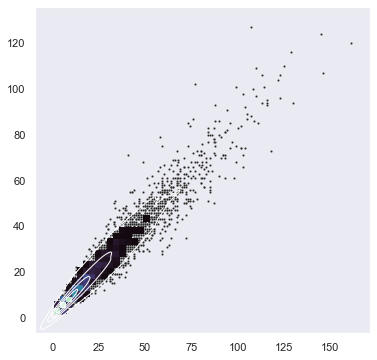

In [24]:
sample = RandomSample(10_000)
sample.update(read())

x=[len(unit.translations['en'].text.split(' ')) for unit in sample]
y=[len(unit.translations['mt'].text.split(' ')) for unit in sample]

sns.set_theme(style="dark")
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)

# Different translations
How many sentence pairs have the same text on one side, but a different one on the other?

In [25]:
from collections import defaultdict
from tqdm.auto import tqdm

def find_doubles(units, lang, threshold=2):
    index = defaultdict(list)
    for unit in tqdm(units):
        index[hash(unit.translations[lang].text)].append(unit)
    return [values for values in index.values() if len(values) >= threshold]

en_text_index = find_doubles(read(), 'en')

  0%|          | 0/1604135 [00:00<?, ?it/s]

  0%|          | 0/1604135 [00:00<?, ?it/s]

In [26]:
f"Number of English sentences with multiple Maltese translations: {len(en_text_index)}"

'Number of English sentences with multiple Maltese translations: 64467'

In [27]:
notebook.table({
    'percentile': '{}%'.format(stop),
    'count': int(count)
} for stop, count in zip(stops, np.percentile([len(vals) for vals in en_text_index], stops)))

percentile,count
10%,2
20%,2
30%,2
40%,2
50%,2
60%,2
70%,2
80%,3
90%,3
91%,3


What are these sentences like?

In [28]:
def first(iteratable, default=None):
    return next(iter(iteratable), default)

In [29]:
notebook.table({
    "English": unit.translations['en'].text,
    "Maltese": unit.translations['mt'].text,
    "score": first(unit['score-bicleaner'])
}
    for similar_units in sorted(en_text_index, key=len, reverse=True)[:10]
    for unit in sorted(similar_units, key=lambda unit: float(first(unit['score-bicleaner'], 0)), reverse=True))

English,Maltese,score
The following shows the options to get started.,Yerangatup Dan li ġej juri l-għażliet biex tikseb beda.,0.874
The following shows the options to get started.,Zafiro Terminal Dan li ġej juri l-għażliet biex tikseb beda.,0.868
The following shows the options to get started.,Uummannaq Dan li ġej juri l-għażliet biex tikseb beda.,0.864
The following shows the options to get started.,Dan li ġej juri l-għażliet biex tikseb beda.,0.858
The following shows the options to get started.,Tsarevo Dan li ġej juri l-għażliet biex tikseb beda.,0.852
The following shows the options to get started.,Afrika t'Isfel Dan li ġej juri l-għażliet biex tibda.,0.850
The following shows the options to get started.,Yirga ‘Alem Dan li ġej juri l-għażliet biex tibda.,0.846
The following shows the options to get started.,Zelenikovo Dan li ġej juri l-assortimenti biex tikseb beda.,0.844
The following shows the options to get started.,Saint Vlas Slavyanovo Dan li ġej juri l-għażliet biex tibda.,0.842
The following shows the options to get started.,Mongomo Dan li ġej juri l-alternattivi biex tikseb beda.,0.840


# Different translations mt -> en

In [30]:
mt_text_index = find_doubles(read(), 'mt')

  0%|          | 0/1604135 [00:00<?, ?it/s]

  0%|          | 0/1604135 [00:00<?, ?it/s]

In [31]:
notebook.table({
    "English": unit.translations['en'].text,
    "Maltese": unit.translations['mt'].text,
    "score": first(unit['score-bicleaner'])
}
    for similar_units in sorted(mt_text_index, key=len, reverse=True)[:10]
    for unit in sorted(similar_units, key=lambda unit: float(first(unit['score-bicleaner'], 0)), reverse=True))

English,Maltese,score
"If you want to be a successful Zambia personal trainer then you need to learn from successful mentors that are ‘in the field’, training clients and running successful fitness businesses.","Jekk inti trid li tkun trejner personali ta’ suċċess, mela trid titgħallem minn għalliema li għamlu suċċessi kbar f’dan il-qasam, li joffru taħriġ lil klijenti u jmexxu negozji tal-fiżika b’suċċess.",0.770
"If you want to be a successful Qala personal trainer then you need to learn from successful mentors that are ‘in the field’, training clients and running successful fitness businesses.","Jekk inti trid li tkun trejner personali ta’ suċċess, mela trid titgħallem minn għalliema li għamlu suċċessi kbar f’dan il-qasam, li joffru taħriġ lil klijenti u jmexxu negozji tal-fiżika b’suċċess.",0.768
"If you want to be a successful Wied Ta’ Baqqiegħa personal trainer then you need to learn from successful mentors that are ‘in the field’, training clients and running successful fitness businesses.","Jekk inti trid li tkun trejner personali ta’ suċċess, mela trid titgħallem minn għalliema li għamlu suċċessi kbar f’dan il-qasam, li joffru taħriġ lil klijenti u jmexxu negozji tal-fiżika b’suċċess.",0.768
"If you want to be a successful Halden personal trainer then you need to learn from successful mentors that are ‘in the field’, training clients and running successful fitness businesses.","Jekk inti trid li tkun trejner personali ta’ suċċess, mela trid titgħallem minn għalliema li għamlu suċċessi kbar f’dan il-qasam, li joffru taħriġ lil klijenti u jmexxu negozji tal-fiżika b’suċċess.",0.766
"If you want to be a successful Anglet personal trainer then you need to learn from successful mentors that are ‘in the field’, training clients and running successful fitness businesses.","Jekk inti trid li tkun trejner personali ta’ suċċess, mela trid titgħallem minn għalliema li għamlu suċċessi kbar f’dan il-qasam, li joffru taħriġ lil klijenti u jmexxu negozji tal-fiżika b’suċċess.",0.766
"If you want to be a successful Qrendi personal trainer then you need to learn from successful mentors that are ‘in the field’, training clients and running successful fitness businesses.","Jekk inti trid li tkun trejner personali ta’ suċċess, mela trid titgħallem minn għalliema li għamlu suċċessi kbar f’dan il-qasam, li joffru taħriġ lil klijenti u jmexxu negozji tal-fiżika b’suċċess.",0.766
"If you want to be a successful Plaisir personal trainer then you need to learn from successful mentors that are ‘in the field’, training clients and running successful fitness businesses.","Jekk inti trid li tkun trejner personali ta’ suċċess, mela trid titgħallem minn għalliema li għamlu suċċessi kbar f’dan il-qasam, li joffru taħriġ lil klijenti u jmexxu negozji tal-fiżika b’suċċess.",0.764
"If you want to be a successful Épernay personal trainer then you need to learn from successful mentors that are ‘in the field’, training clients and running successful fitness businesses.","Jekk inti trid li tkun trejner personali ta’ suċċess, mela trid titgħallem minn għalliema li għamlu suċċessi kbar f’dan il-qasam, li joffru taħriġ lil klijenti u jmexxu negozji tal-fiżika b’suċċess.",0.764
"If you want to be a successful Dijon personal trainer then you need to learn from successful mentors that are ‘in the field’, training clients and running successful fitness businesses.","Jekk inti trid li tkun trejner personali ta’ suċċess, mela trid titgħallem minn għalliema li għamlu suċċessi kbar f’dan il-qasam, li joffru taħriġ lil klijenti u jmexxu negozji tal-fiżika b’suċċess.",0.762
"If you want to be a successful Marfa personal trainer then you need to learn from successful mentors that are ‘in the field’, training clients and running successful fitness businesses.","Jekk inti trid li tkun trejner personali ta’ suċċess, mela trid titgħallem minn għalliema li għamlu suċċessi kbar f’dan il-qasam, li joffru taħriġ lil klijenti u jmexxu negozji tal-fiżika b’suċċess.",0.762
